In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [2]:
def mostrar_imagenes(lista_imagenes, titulos, filas=1, columnas=2, size=(10, 5)):
    """
    Muestra una lista de imágenes en una cuadricula con Matplotlib.
    :param lista_imagenes: Lista de imágenes en formato BGR o RGB.
    :param titulos: Lista de títulos para cada imagen.
    :param filas: Número de filas en la cuadrícula.
    :param columnas: Número de columnas en la cuadrícula.
    :param size: Tamaño de la figura (ancho, alto) en pulgadas.
    """
    plt.figure(figsize=size)
    for i, (img, tit) in enumerate(zip(lista_imagenes, titulos)):
        plt.subplot(filas, columnas, i+1)
        # Si la imagen está en BGR, la convertimos a RGB para mostrarla correctamente
        if len(img.shape) == 3 and img.shape[2] == 3:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img_rgb = img
        plt.imshow(img_rgb, cmap='gray')
        plt.title(tit)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
# ============================================================================
# 1. Cargar la imagen
# ============================================================================

imagen_original = cv2.imread("Gato/gato.jpg")

# Verificamos que se haya cargado la imagen
if imagen_original is None:
    raise ValueError("No se pudo leer la imagen. Verifica la ruta.")

# Redimensionar la imagen (opcional) para acelerar el proceso y visualizar mejor
imagen = cv2.resize(imagen_original, (256, 256), interpolation=cv2.INTER_AREA)

In [ ]:
# ============================================================================
# 2. Preprocesamiento: convertir imagen a array de características
# ============================================================================
# Para el clustering, representaremos cada píxel por sus valores de color.
# Podemos trabajar en el espacio de color RGB o, en ocasiones, en otros espacios
# (HSV, Lab, etc.). Aquí usaremos el RGB sencillo.
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Obtenemos las dimensiones de la imagen: alto, ancho, canales
alto, ancho, canales = imagen_rgb.shape

# Aplanamos la imagen en un array de forma (alto*ancho, canales)
# cada fila es un píxel, cada columna es un canal de color.
datos = imagen_rgb.reshape(-1, canales)
imagen_2d=datos

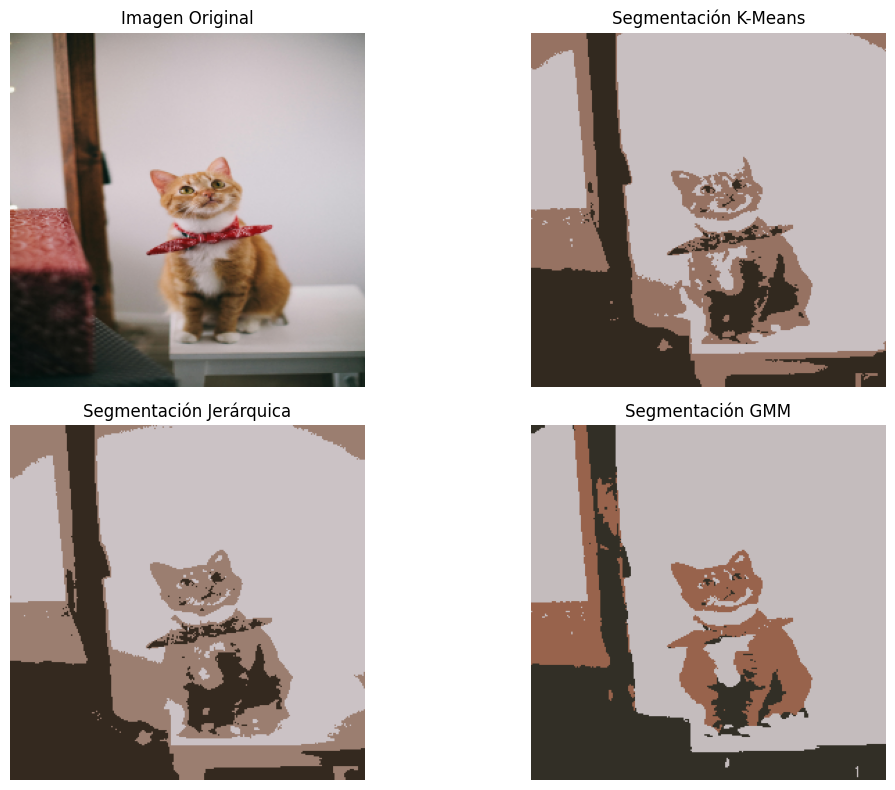

In [10]:
# ----------------------------------------------------------
# 2. K-MEANS
# ----------------------------------------------------------
# Definimos el número de clústers (ejemplo: 3)
k_clusters = 3
kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init="auto")

# Ajustar y predecir las etiquetas de cada píxel
labels_kmeans = kmeans.fit_predict(imagen_2d)

# Reconstruir la imagen segmentada
segmentada_kmeans = kmeans.cluster_centers_.astype(np.uint8)[labels_kmeans]
segmentada_kmeans = segmentada_kmeans.reshape(alto, ancho, 3)

# ----------------------------------------------------------
# 3. CLUSTERING JERÁRQUICO (AGGLOMERATIVE)
# ----------------------------------------------------------
# Definimos el número de clústers (ejemplo: 3)
hj_clusters = 3
hc = AgglomerativeClustering(n_clusters=hj_clusters, linkage='ward')

# Ajustar y predecir las etiquetas
labels_hc = hc.fit_predict(imagen_2d)

# Para reconstruir la imagen segmentada, necesitamos calcular 
# el color medio de cada clúster
segmentada_hc = np.zeros_like(imagen_2d)
for cluster_idx in range(hj_clusters):
    # Máscara booleana para los píxeles del clúster en cuestión
    mask = (labels_hc == cluster_idx)
    # Promedio de color para ese clúster
    promedio = imagen_2d[mask].mean(axis=0).astype(np.uint8)
    segmentada_hc[mask] = promedio

# Dar forma de nuevo (alto, ancho, 3)
segmentada_hc = segmentada_hc.reshape(alto, ancho, 3)

# ----------------------------------------------------------
# 4. GAUSSIAN MIXTURE MODEL (GMM)
# ----------------------------------------------------------
# Definimos el número de componentes (ejemplo: 3)
gmm_clusters = 3
gmm = GaussianMixture(n_components=gmm_clusters, covariance_type='tied', random_state=42)

# Ajustar y predecir las etiquetas
gmm.fit(imagen_2d)
labels_gmm = gmm.predict(imagen_2d)

# De nuevo, calculamos el color promedio de cada clúster
segmentada_gmm = np.zeros_like(imagen_2d)
for cluster_idx in range(gmm_clusters):
    mask = (labels_gmm == cluster_idx)
    promedio = imagen_2d[mask].mean(axis=0).astype(np.uint8)
    segmentada_gmm[mask] = promedio

# Dar forma a (alto, ancho, 3)
segmentada_gmm = segmentada_gmm.reshape(alto, ancho, 3)

# ----------------------------------------------------------
# 5. MOSTRAR RESULTADOS
# ----------------------------------------------------------
plt.figure(figsize=(12, 8))

# Imagen original
plt.subplot(2, 2, 1)
plt.imshow(imagen_rgb)
plt.title('Imagen Original')
plt.axis('off')

# Segmentada por K-Means
plt.subplot(2, 2, 2)
plt.imshow(segmentada_kmeans)
plt.title('Segmentación K-Means')
plt.axis('off')

# Segmentada por Clustering Jerárquico
plt.subplot(2, 2, 3)
plt.imshow(segmentada_hc)
plt.title('Segmentación Jerárquica')
plt.axis('off')

# Segmentada por GMM
plt.subplot(2, 2, 4)
plt.imshow(segmentada_gmm)
plt.title('Segmentación GMM')
plt.axis('off')

plt.tight_layout()
plt.show()


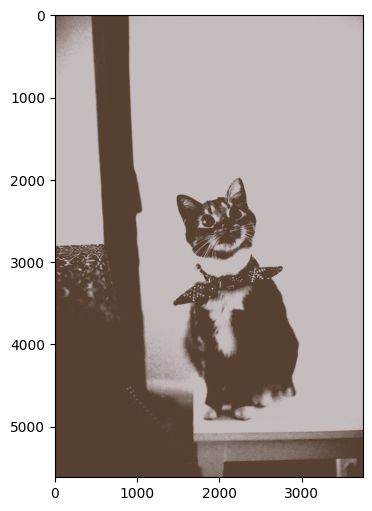

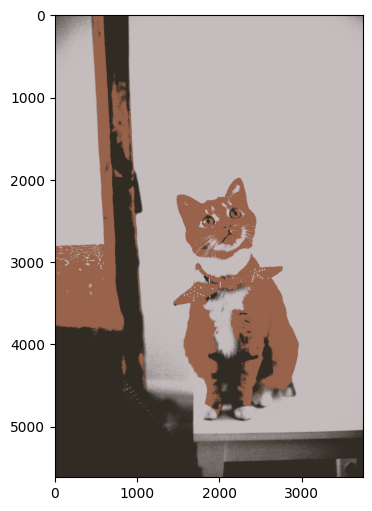

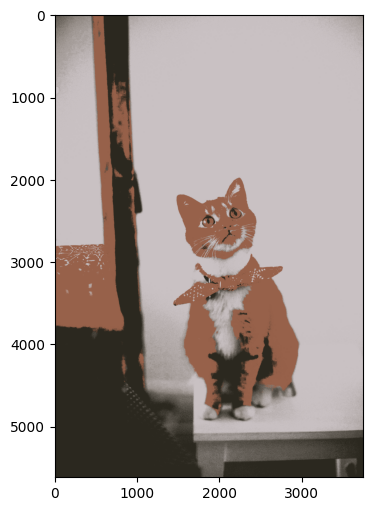

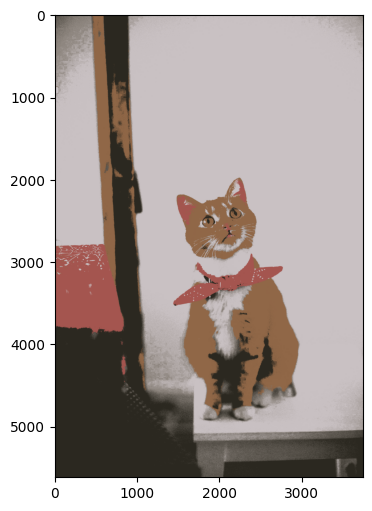

In [11]:
img = plt.imread('Gato/gato.jpg')

# If img is greyscale, then change to .reshape(-1, 1):
X = img.reshape(-1, 3)
for n in range(2,6):
    gmm = GaussianMixture(n_components=n, covariance_type='tied')
    gmm.fit(X)
    labels = gmm.predict(X) # num of pixels x 1
    seg = np.zeros(X.shape) # num of pixels x 3
    for label in range(n):
        seg[labels == label] = gmm.means_[label]
    seg = seg.reshape(img.shape).astype(np.uint8)

    plt.figure(figsize=(6,6))
    plt.imshow(seg)